<a href="https://colab.research.google.com/github/ricoprediansyah/CV-FASTER_RCNN-COCO/blob/main/FASTER_RCNN_COCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:07
🔁 Restarting kernel...


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="PZMfN1gExhcqfGkkkd43")
project = rf.workspace("rico-prediansyah").project("myface-v1gul")
version = project.version(1)
dataset = version.download("tensorflow")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to MyFace-1 in tensorflow:: 100%|██████████| 41/41 [00:00<00:00, 5650.10it/s]


In [ ]:
! conda install pytorch=1.1.0 torchvision -c pytorch -y

Channels:
 - pytorch
 - conda-forge
Platform: linux-64
Solving environment: - \ | / failed

PackagesNotFoundError: The following packages are not available from current channels:

  - pytorch=1.1.0*

Current channels:

  - https://conda.anaconda.org/pytorch
  - https://conda.anaconda.org/conda-forge

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [ ]:
import torchvision
from torchvision import  transforms
import torch
from torch import no_grad

In [ ]:
import requests

In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
def get_predictions(pred, threshold=0.8, objects=None):
    """
    This function will assign a string name to a predicted class and eliminate predictions whose likelihood  is under a threshold

    pred: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class yhat, probability of belonging to that class and the coordinates of the bounding box corresponding to the object
    image : frozen surface
    predicted_classes: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object
    thre
    """


    predicted_classes= [(COCO_INSTANCE_CATEGORY_NAMES[i],p,[(box[0], box[1]), (box[2], box[3])]) for i,p,box in zip(list(pred[0]['labels'].numpy()),pred[0]['scores'].detach().numpy(),list(pred[0]['boxes'].detach().numpy()))]
    predicted_classes=[  stuff  for stuff in predicted_classes  if stuff[1]>threshold ]

    if objects  and predicted_classes :
        predicted_classes=[ (name, p, box) for name, p, box in predicted_classes if name in  objects ]
    return predicted_classes

In [ ]:
def draw_box(pred_class, img, rect_th=2, text_size=0.5, text_th=2, download_image=False, img_name="img"):
    """
    draws box around each object

    predicted_classes: a list where each element contains a tuple that corresponds to information about the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object
    image : frozen surface

    """
    image = (np.clip(cv2.cvtColor(np.clip(img.numpy().transpose((1, 2, 0)), 0, 1), cv2.COLOR_RGB2BGR), 0, 1) * 255).astype(np.uint8).copy()

    for predicted_class in pred_class:

      label=predicted_class[0]
      probability=predicted_class[1]
      box=predicted_class[2]
      t = round(box[0][0].tolist())
      l = round(box[0][1].tolist())
      r = round(box[1][0].tolist())
      b = round(box[1][1].tolist())

      # Giving brief information about rectange, class and probability.
      from colorama import Fore
      from colorama import Style
      print(f"\nLabel: {Fore.GREEN}{label}{Style.RESET_ALL}")
      print(f"Box coordinates: {t}, {l}, {r}, {b}")
      print(f"Probability: {probability}")

      # Drawing rectangle and adding text on the picture based on their class and size.
      cv2.rectangle(image, (t, l), (r, b), (0, 255, 0), rect_th)
      cv2.rectangle(image, (t, l), (t+110, l+17), (255, 255, 255), -1)
      cv2.putText(image, label, (t+10, l+12),  cv2.FONT_HERSHEY_SIMPLEX,
                  text_size, (0,255,0), thickness=text_th)
      cv2.putText(image, label+": "+str(round(probability, 2)),
                  (t+10, l+12),  cv2.FONT_HERSHEY_SIMPLEX, text_size,
                  (0, 255, 0),thickness=text_th)

    # Plotting image
    image = np.array(image)
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if download_image:
      plt.savefig(f'{img_name}.png')
    else:
      pass
    plt.show()

    del(img)
    del(image)

In [ ]:
def save_RAM(image_=False):
    global image, img, pred
    torch.cuda.empty_cache()
    del(img)
    del(pred)
    if image_:
        image.close()
        del(image)

##**Load Pre-trained Faster R-CNN**

Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image pre-trained on COCO. Faster R-CNN model with a ResNet-50-FPN backbone from the Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks paper.



In [ ]:
model_ = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_.eval()

for name, param in model_.named_parameters():
    param.requires_grad = False
print("done")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


done


In [ ]:
def model(x):
    with torch.no_grad():
        yhat = model_(x)
    return yhat

In [ ]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
len(COCO_INSTANCE_CATEGORY_NAMES)

91

##**Object Localization**
In Object Localization we locate the presence of objects in an image and indicate the location with a bounding box. Consider the image of Andrew Ng

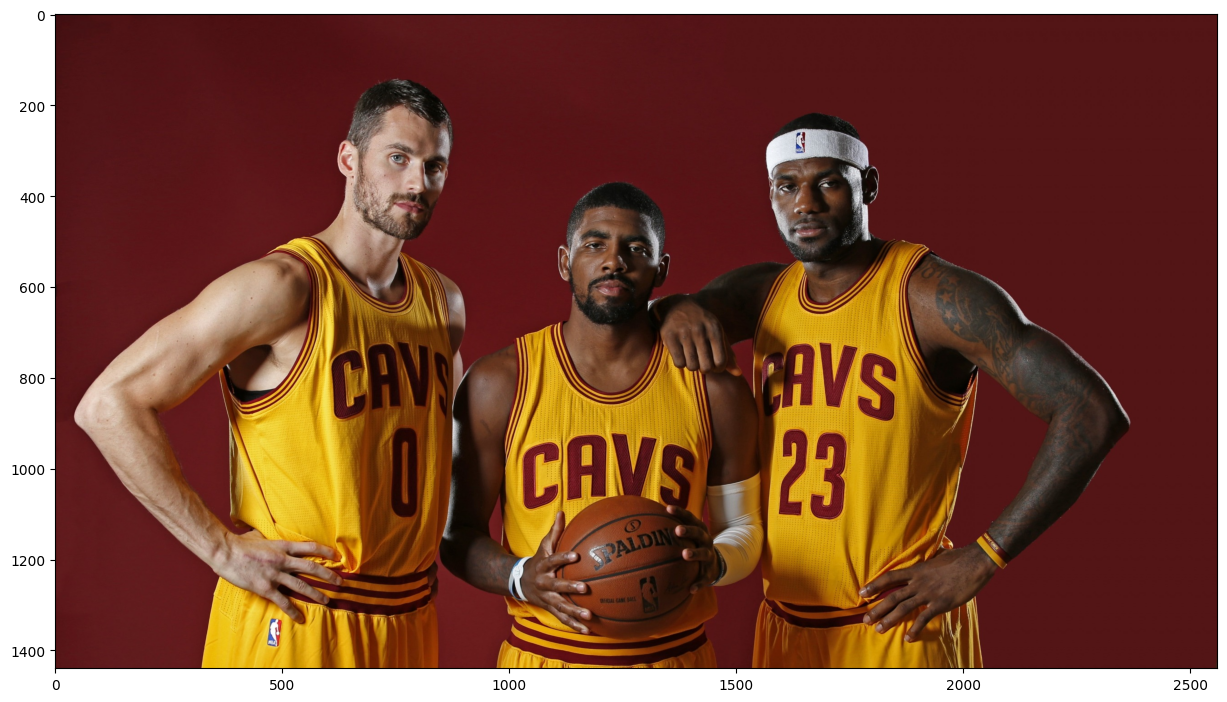

In [ ]:
img_path='basket.jpg'
half = 0.5
image = Image.open(img_path)

image.resize([int(half * s) for s in image.size] )
plt.figure(figsize=(15, 10))
plt.imshow(image)
plt.show()

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
img = transform(image)
img

tensor([[[0.2549, 0.2549, 0.2588,  ..., 0.3255, 0.3255, 0.3255],
         [0.2510, 0.2549, 0.2549,  ..., 0.3255, 0.3255, 0.3255],
         [0.2471, 0.2471, 0.2510,  ..., 0.3255, 0.3255, 0.3255],
         ...,
         [0.3412, 0.3412, 0.3373,  ..., 0.2431, 0.2235, 0.2235],
         [0.3412, 0.3373, 0.3373,  ..., 0.2431, 0.2235, 0.2275],
         [0.3412, 0.3412, 0.3373,  ..., 0.2431, 0.2314, 0.2392]],

        [[0.0588, 0.0588, 0.0627,  ..., 0.0824, 0.0824, 0.0824],
         [0.0549, 0.0588, 0.0588,  ..., 0.0824, 0.0824, 0.0824],
         [0.0549, 0.0549, 0.0588,  ..., 0.0824, 0.0824, 0.0824],
         ...,
         [0.0902, 0.0902, 0.0863,  ..., 0.1686, 0.1725, 0.1804],
         [0.0902, 0.0863, 0.0863,  ..., 0.1686, 0.1725, 0.1843],
         [0.0902, 0.0902, 0.0863,  ..., 0.1686, 0.1804, 0.1961]],

        [[0.0706, 0.0706, 0.0745,  ..., 0.0863, 0.0863, 0.0863],
         [0.0667, 0.0706, 0.0706,  ..., 0.0863, 0.0863, 0.0863],
         [0.0667, 0.0667, 0.0706,  ..., 0.0863, 0.0863, 0.

In [ ]:
pred = model([img])
len(pred[0]['labels'])
pred[0]['labels']

tensor([ 1,  1,  1, 40, 37,  1, 27])

In [ ]:
pred[0]['scores']
index=pred[0]['labels'][0].item()
COCO_INSTANCE_CATEGORY_NAMES[index]
bounding_box=pred[0]['boxes'][0].tolist()
bounding_box

[54.6811408996582, 122.55215454101562, 958.9602661132812, 1423.7451171875]

In [ ]:
t, l, r, b = [round(x) for x in bounding_box]
print(t, l, r, b)

55 123 959 1424


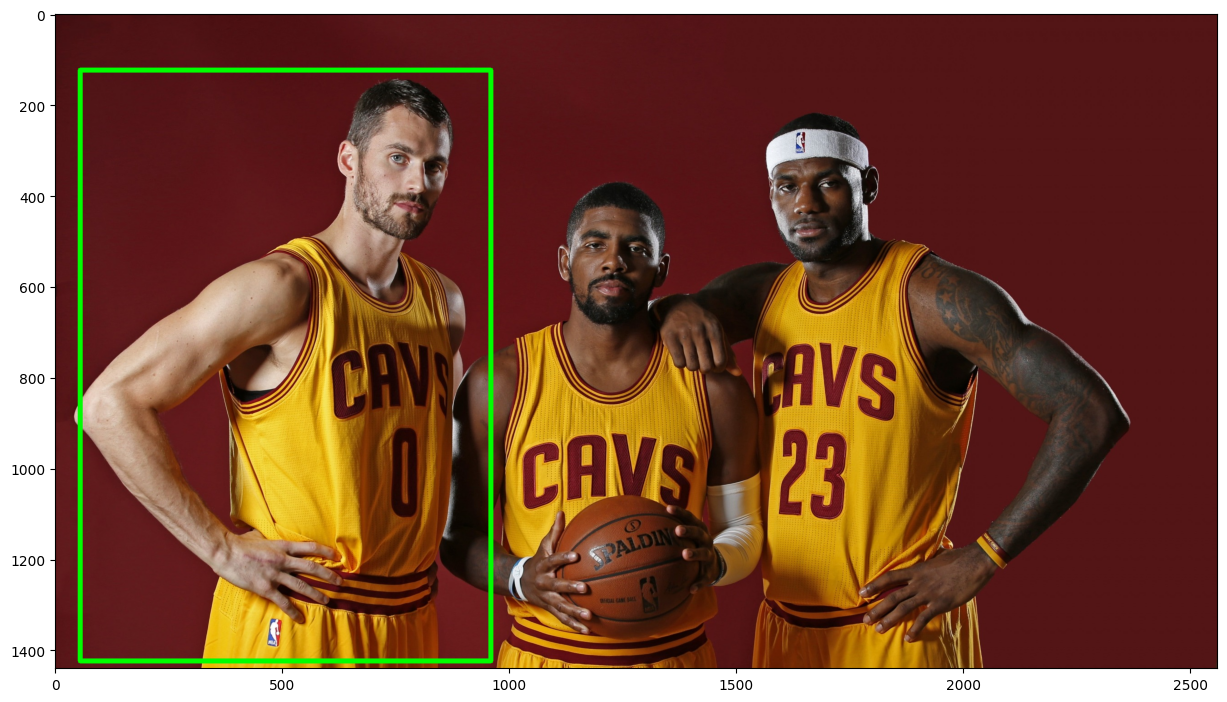

In [ ]:
img_plot=(np.clip(cv2.cvtColor(np.clip(img.numpy().transpose((1, 2, 0)), 0, 1), cv2.COLOR_RGB2BGR), 0, 1) * 255).astype(np.uint8)
cv2.rectangle(img_plot, (t, l), (r, b), (0, 255, 0), 10) # Draw Rectangle with the coordinates
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
plt.show()
del img_plot, t, l, r, b


Label: person
Box coordinates: 55, 123, 959, 1424
Probability: 0.9988393187522888

Label: person
Box coordinates: 1257, 211, 2393, 1440
Probability: 0.9978893399238586

Label: person
Box coordinates: 847, 364, 1576, 1438
Probability: 0.9965906143188477


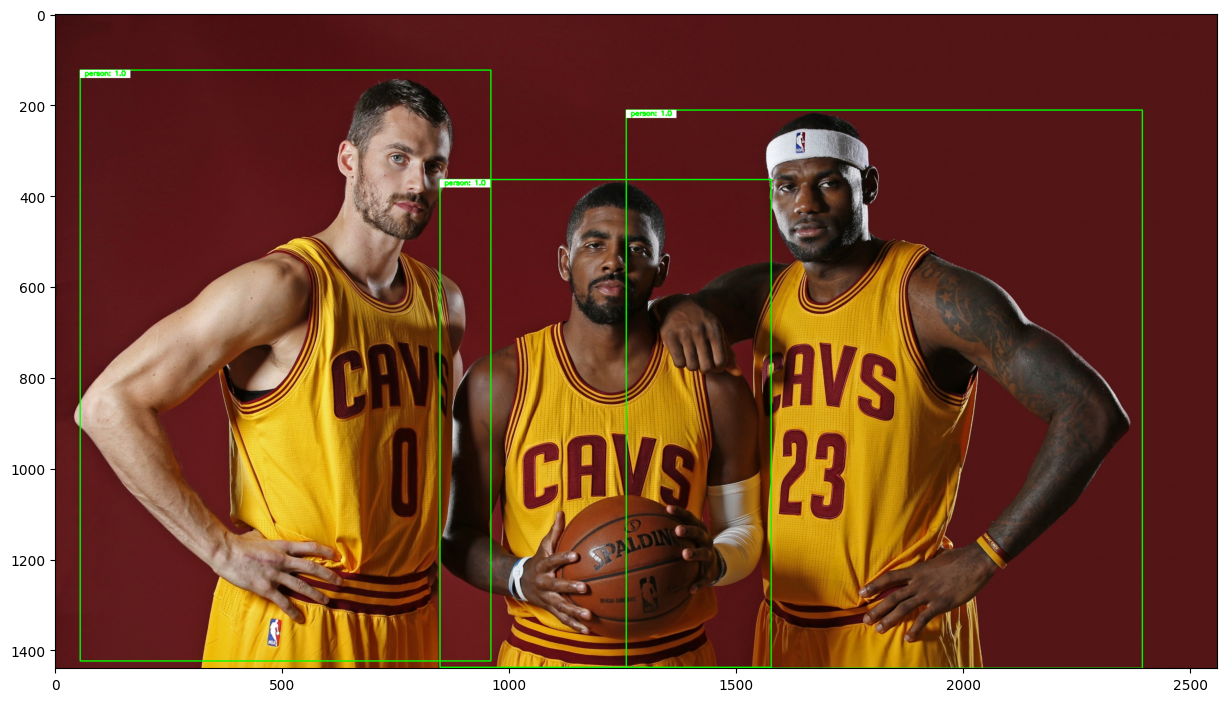

In [ ]:
pred_class=get_predictions(pred, objects="person")
draw_box(pred_class, img)

del pred_class


Label: person
Box coordinates: 55, 123, 959, 1424
Probability: 0.9988393187522888

Label: person
Box coordinates: 1257, 211, 2393, 1440
Probability: 0.9978893399238586

Label: person
Box coordinates: 847, 364, 1576, 1438
Probability: 0.9965906143188477


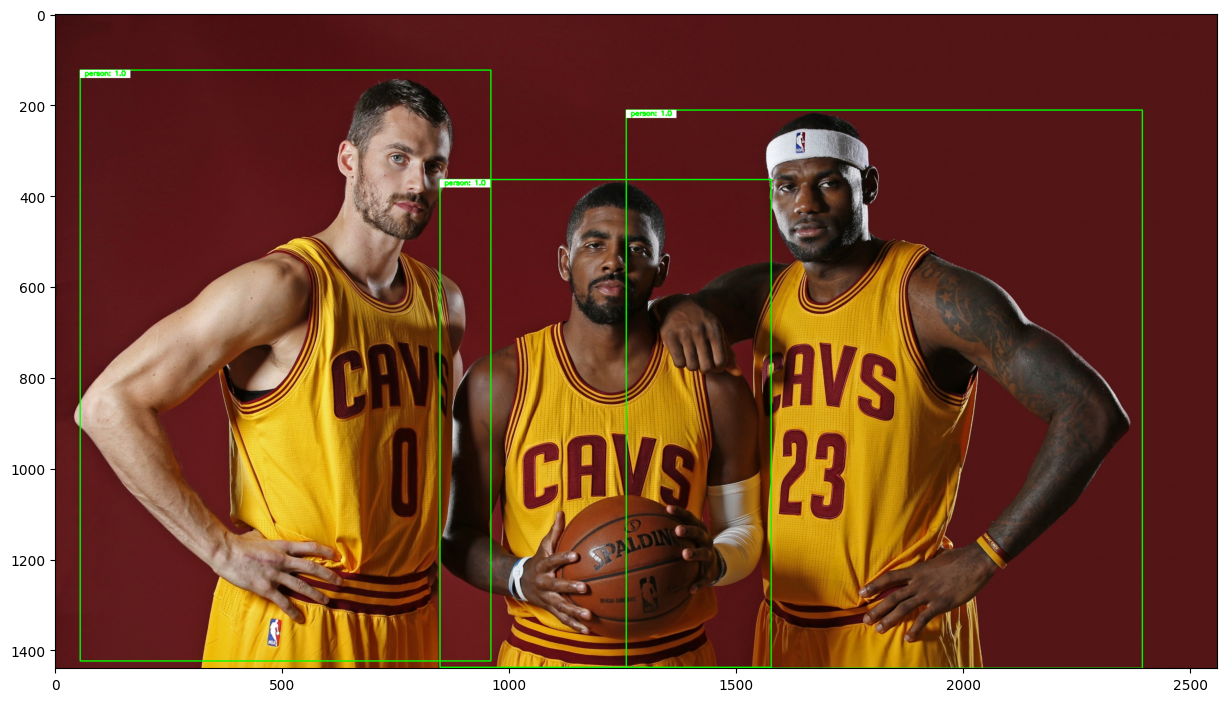

In [ ]:
get_predictions(pred, threshold=1, objects="person")

pred_thresh=get_predictions(pred, threshold=0.98, objects="person")
draw_box(pred_thresh, img, download_image=True, img_name="basket_BOX")
del pred_thresh

In [ ]:
save_RAM(image_=True)